# Question2- Part b

In [3]:
project_name = 'course-project-abstract-dcgan'
from google.colab import drive
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/archive_2.zip"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/archive_2.zip
replace Abstract_gallery/Abstract_gallery/Abstract_image_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od
import os

DATA_DIR = '/content/Abstract_gallery'
print(os.listdir(DATA_DIR))
print(os.listdir(DATA_DIR+'/Abstract_gallery')[:10])

['Abstract_gallery']
['Abstract_image_172.jpg', 'Abstract_image_1561.jpg', 'Abstract_image_2432.jpg', 'Abstract_image_1516.jpg', 'Abstract_image_1210.jpg', 'Abstract_image_213.jpg', 'Abstract_image_1575.jpg', 'Abstract_image_469.jpg', 'Abstract_image_1173.jpg', 'Abstract_image_964.jpg']


> Normalization, ImageFolder, DataLoader

In [5]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T


image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


> Functions for denormalizing image tensors and displaying a training batch

In [6]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch
%matplotlib inline

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

> Display a training batch

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


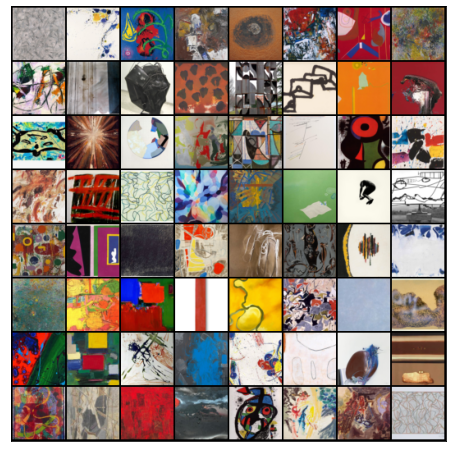

In [7]:
show_batch(train_dl)

In [8]:
!pip install jovian --upgrade --quiet

     |████████████████████████████████| 68 kB 4.3 MB/s 


> For using a GPU (if one is available)

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
train_dl = DeviceDataLoader(train_dl, device)

>Discriminator Model

In [12]:
import torch.nn as nn

discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

>moving discriminator model to the chosen device

In [13]:
discriminator = to_device(discriminator, device)

> Generator Model

In [14]:
latent_size = 128
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

> Generating some images and denormalize them and display them

torch.Size([128, 128, 1, 1])
torch.Size([128, 3, 64, 64])


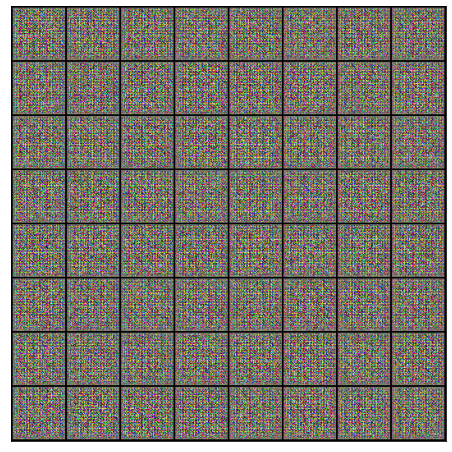

In [15]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
print(xb.shape)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

>moving discriminator model to the chosen device

In [16]:
generator = to_device(generator, device)

> Training discriminator

In [17]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

>Training Generator

In [18]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

> Saving the outputs of the generator

In [19]:
from torchvision.utils import save_image

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

> Fixed input vectors

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


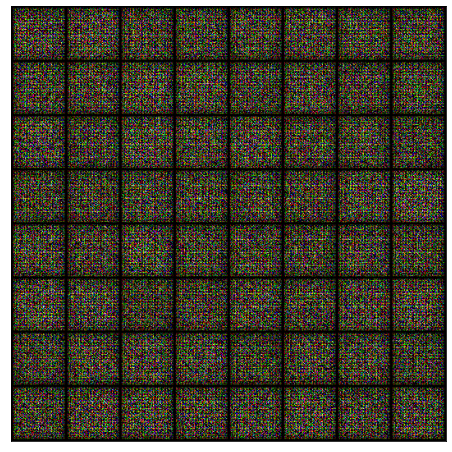

In [20]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
save_samples(0, fixed_latent)

>Fit Function for training loop

In [21]:
from tqdm.notebook import tqdm
import torch.nn.functional as F
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

>Train the model

In [22]:
lr = 0.0001
epochs = 200
history = fit(epochs, lr)

  0%|          | 0/22 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1/200], loss_g: 5.5508, loss_d: 0.4843, real_score: 0.8057, fake_score: 0.2204
Saving generated-images-0001.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [2/200], loss_g: 6.3579, loss_d: 0.1414, real_score: 0.9321, fake_score: 0.0661
Saving generated-images-0002.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [3/200], loss_g: 6.2949, loss_d: 0.0644, real_score: 0.9713, fake_score: 0.0336
Saving generated-images-0003.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [4/200], loss_g: 7.1203, loss_d: 0.0624, real_score: 0.9757, fake_score: 0.0367
Saving generated-images-0004.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [5/200], loss_g: 7.9329, loss_d: 0.0628, real_score: 0.9851, fake_score: 0.0461
Saving generated-images-0005.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [6/200], loss_g: 6.1032, loss_d: 0.0962, real_score: 0.9493, fake_score: 0.0386
Saving generated-images-0006.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [7/200], loss_g: 8.5611, loss_d: 0.7497, real_score: 0.9872, fake_score: 0.3120
Saving generated-images-0007.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [8/200], loss_g: 11.0201, loss_d: 1.2421, real_score: 0.9805, fake_score: 0.6680
Saving generated-images-0008.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [9/200], loss_g: 5.1874, loss_d: 0.1041, real_score: 0.9488, fake_score: 0.0484
Saving generated-images-0009.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [10/200], loss_g: 5.9838, loss_d: 0.1017, real_score: 0.9502, fake_score: 0.0471
Saving generated-images-0010.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [11/200], loss_g: 7.1336, loss_d: 0.2691, real_score: 0.9014, fake_score: 0.1185
Saving generated-images-0011.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [12/200], loss_g: 7.3223, loss_d: 0.1347, real_score: 0.8924, fake_score: 0.0023
Saving generated-images-0012.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [13/200], loss_g: 5.8757, loss_d: 0.0494, real_score: 0.9749, fake_score: 0.0232
Saving generated-images-0013.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [14/200], loss_g: 5.9169, loss_d: 0.0327, real_score: 0.9848, fake_score: 0.0171
Saving generated-images-0014.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [15/200], loss_g: 4.6838, loss_d: 0.0659, real_score: 0.9520, fake_score: 0.0140
Saving generated-images-0015.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [16/200], loss_g: 5.8840, loss_d: 0.0309, real_score: 0.9841, fake_score: 0.0146
Saving generated-images-0016.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [17/200], loss_g: 6.0857, loss_d: 0.0258, real_score: 0.9891, fake_score: 0.0146
Saving generated-images-0017.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [18/200], loss_g: 6.4899, loss_d: 0.0209, real_score: 0.9923, fake_score: 0.0130
Saving generated-images-0018.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [19/200], loss_g: 2.5742, loss_d: 0.5198, real_score: 0.8946, fake_score: 0.3119
Saving generated-images-0019.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [20/200], loss_g: 3.8575, loss_d: 0.1395, real_score: 0.9187, fake_score: 0.0501
Saving generated-images-0020.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [21/200], loss_g: 4.8319, loss_d: 0.1098, real_score: 0.9461, fake_score: 0.0500
Saving generated-images-0021.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [22/200], loss_g: 3.7837, loss_d: 0.1237, real_score: 0.9718, fake_score: 0.0875
Saving generated-images-0022.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [23/200], loss_g: 3.8851, loss_d: 0.6342, real_score: 0.9861, fake_score: 0.2823
Saving generated-images-0023.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [24/200], loss_g: 1.9452, loss_d: 0.2906, real_score: 0.7958, fake_score: 0.0251
Saving generated-images-0024.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [25/200], loss_g: 3.9724, loss_d: 0.2669, real_score: 0.8621, fake_score: 0.0945
Saving generated-images-0025.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [26/200], loss_g: 4.0053, loss_d: 0.2116, real_score: 0.8953, fake_score: 0.0753
Saving generated-images-0026.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [27/200], loss_g: 5.4926, loss_d: 0.2974, real_score: 0.9588, fake_score: 0.2128
Saving generated-images-0027.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [28/200], loss_g: 3.4570, loss_d: 0.3672, real_score: 0.8222, fake_score: 0.1302
Saving generated-images-0028.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [29/200], loss_g: 3.6416, loss_d: 0.3279, real_score: 0.7957, fake_score: 0.0428
Saving generated-images-0029.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [30/200], loss_g: 4.6666, loss_d: 0.3096, real_score: 0.8094, fake_score: 0.0517
Saving generated-images-0030.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [31/200], loss_g: 2.4868, loss_d: 0.4534, real_score: 0.7315, fake_score: 0.0370
Saving generated-images-0031.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [32/200], loss_g: 3.6527, loss_d: 0.1544, real_score: 0.9315, fake_score: 0.0739
Saving generated-images-0032.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [33/200], loss_g: 6.4367, loss_d: 0.0817, real_score: 0.9671, fake_score: 0.0431
Saving generated-images-0033.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [34/200], loss_g: 5.8413, loss_d: 0.2154, real_score: 0.8415, fake_score: 0.0181
Saving generated-images-0034.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [35/200], loss_g: 4.3382, loss_d: 0.2919, real_score: 0.9354, fake_score: 0.1666
Saving generated-images-0035.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [36/200], loss_g: 3.4537, loss_d: 0.2483, real_score: 0.8508, fake_score: 0.0549
Saving generated-images-0036.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [37/200], loss_g: 2.5247, loss_d: 0.6679, real_score: 0.6789, fake_score: 0.0998
Saving generated-images-0037.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [38/200], loss_g: 2.0406, loss_d: 0.4263, real_score: 0.7339, fake_score: 0.0416
Saving generated-images-0038.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [39/200], loss_g: 4.2597, loss_d: 2.3483, real_score: 0.2178, fake_score: 0.0008
Saving generated-images-0039.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [40/200], loss_g: 3.5540, loss_d: 0.3239, real_score: 0.8707, fake_score: 0.1409
Saving generated-images-0040.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [41/200], loss_g: 4.3569, loss_d: 0.3431, real_score: 0.7499, fake_score: 0.0162
Saving generated-images-0041.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [42/200], loss_g: 3.6286, loss_d: 0.1918, real_score: 0.8821, fake_score: 0.0510
Saving generated-images-0042.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [43/200], loss_g: 1.8994, loss_d: 0.3091, real_score: 0.7926, fake_score: 0.0473
Saving generated-images-0043.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [44/200], loss_g: 2.3351, loss_d: 0.2500, real_score: 0.8679, fake_score: 0.0872
Saving generated-images-0044.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [45/200], loss_g: 6.2876, loss_d: 0.4707, real_score: 0.9791, fake_score: 0.3295
Saving generated-images-0045.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [46/200], loss_g: 3.0666, loss_d: 0.3502, real_score: 0.7741, fake_score: 0.0484
Saving generated-images-0046.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [47/200], loss_g: 4.6190, loss_d: 0.2316, real_score: 0.8716, fake_score: 0.0674
Saving generated-images-0047.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [48/200], loss_g: 3.9701, loss_d: 0.5338, real_score: 0.6980, fake_score: 0.0162
Saving generated-images-0048.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [49/200], loss_g: 2.0644, loss_d: 0.3699, real_score: 0.7650, fake_score: 0.0450
Saving generated-images-0049.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [50/200], loss_g: 5.0473, loss_d: 0.3270, real_score: 0.9536, fake_score: 0.2232
Saving generated-images-0050.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [51/200], loss_g: 4.6044, loss_d: 0.3433, real_score: 0.8878, fake_score: 0.1706
Saving generated-images-0051.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [52/200], loss_g: 4.8037, loss_d: 0.3832, real_score: 0.9366, fake_score: 0.2482
Saving generated-images-0052.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [53/200], loss_g: 3.1558, loss_d: 0.2511, real_score: 0.8703, fake_score: 0.0930
Saving generated-images-0053.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [54/200], loss_g: 4.0934, loss_d: 0.5656, real_score: 0.8411, fake_score: 0.2756
Saving generated-images-0054.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [55/200], loss_g: 3.1377, loss_d: 0.3190, real_score: 0.8611, fake_score: 0.0999
Saving generated-images-0055.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [56/200], loss_g: 3.3304, loss_d: 0.2059, real_score: 0.9038, fake_score: 0.0821
Saving generated-images-0056.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [57/200], loss_g: 4.3360, loss_d: 0.4152, real_score: 0.7692, fake_score: 0.0615
Saving generated-images-0057.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [58/200], loss_g: 2.9168, loss_d: 0.4033, real_score: 0.7843, fake_score: 0.0963
Saving generated-images-0058.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [59/200], loss_g: 5.4148, loss_d: 0.1359, real_score: 0.9089, fake_score: 0.0324
Saving generated-images-0059.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [60/200], loss_g: 1.6224, loss_d: 0.7048, real_score: 0.5726, fake_score: 0.0279
Saving generated-images-0060.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [61/200], loss_g: 3.7662, loss_d: 0.3070, real_score: 0.8466, fake_score: 0.1093
Saving generated-images-0061.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [62/200], loss_g: 4.1363, loss_d: 0.2636, real_score: 0.9051, fake_score: 0.1227
Saving generated-images-0062.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [63/200], loss_g: 8.4600, loss_d: 0.9828, real_score: 0.9305, fake_score: 0.5318
Saving generated-images-0063.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [64/200], loss_g: 3.7290, loss_d: 0.4085, real_score: 0.8289, fake_score: 0.1681
Saving generated-images-0064.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [65/200], loss_g: 3.0423, loss_d: 0.8760, real_score: 0.4766, fake_score: 0.0124
Saving generated-images-0065.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [66/200], loss_g: 5.1258, loss_d: 0.2066, real_score: 0.9064, fake_score: 0.0921
Saving generated-images-0066.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [67/200], loss_g: 4.9335, loss_d: 0.3293, real_score: 0.9657, fake_score: 0.2243
Saving generated-images-0067.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [68/200], loss_g: 5.2874, loss_d: 0.4070, real_score: 0.8931, fake_score: 0.2357
Saving generated-images-0068.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [69/200], loss_g: 4.7978, loss_d: 0.5484, real_score: 0.9378, fake_score: 0.3437
Saving generated-images-0069.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [70/200], loss_g: 4.8885, loss_d: 0.3995, real_score: 0.9415, fake_score: 0.2658
Saving generated-images-0070.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [71/200], loss_g: 5.2835, loss_d: 0.4762, real_score: 0.9627, fake_score: 0.3172
Saving generated-images-0071.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [72/200], loss_g: 7.3132, loss_d: 0.8868, real_score: 0.9545, fake_score: 0.5156
Saving generated-images-0072.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [73/200], loss_g: 2.3682, loss_d: 0.7539, real_score: 0.5959, fake_score: 0.0593
Saving generated-images-0073.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [74/200], loss_g: 3.8055, loss_d: 0.3954, real_score: 0.8636, fake_score: 0.1921
Saving generated-images-0074.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [75/200], loss_g: 2.7998, loss_d: 0.3371, real_score: 0.7937, fake_score: 0.0700
Saving generated-images-0075.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [76/200], loss_g: 2.7671, loss_d: 0.3429, real_score: 0.8563, fake_score: 0.1528
Saving generated-images-0076.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [77/200], loss_g: 2.6654, loss_d: 0.2466, real_score: 0.8354, fake_score: 0.0463
Saving generated-images-0077.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [78/200], loss_g: 4.9646, loss_d: 0.3063, real_score: 0.7676, fake_score: 0.0178
Saving generated-images-0078.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [79/200], loss_g: 2.9543, loss_d: 0.3220, real_score: 0.7994, fake_score: 0.0749
Saving generated-images-0079.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [80/200], loss_g: 3.2108, loss_d: 0.2855, real_score: 0.8431, fake_score: 0.0973
Saving generated-images-0080.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [81/200], loss_g: 3.1730, loss_d: 0.3784, real_score: 0.8135, fake_score: 0.1335
Saving generated-images-0081.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [82/200], loss_g: 2.2359, loss_d: 1.4404, real_score: 0.3190, fake_score: 0.0114
Saving generated-images-0082.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [83/200], loss_g: 4.0196, loss_d: 0.5076, real_score: 0.7914, fake_score: 0.2046
Saving generated-images-0083.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [84/200], loss_g: 3.0559, loss_d: 0.3247, real_score: 0.8216, fake_score: 0.1068
Saving generated-images-0084.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [85/200], loss_g: 2.5416, loss_d: 0.2618, real_score: 0.9098, fake_score: 0.1336
Saving generated-images-0085.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [86/200], loss_g: 1.3643, loss_d: 0.8991, real_score: 0.5023, fake_score: 0.0491
Saving generated-images-0086.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [87/200], loss_g: 3.1283, loss_d: 0.3911, real_score: 0.8728, fake_score: 0.1979
Saving generated-images-0087.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [88/200], loss_g: 3.5982, loss_d: 0.3975, real_score: 0.9450, fake_score: 0.2546
Saving generated-images-0088.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [89/200], loss_g: 3.6052, loss_d: 0.3628, real_score: 0.8364, fake_score: 0.1449
Saving generated-images-0089.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [90/200], loss_g: 3.1182, loss_d: 1.0611, real_score: 0.4163, fake_score: 0.0084
Saving generated-images-0090.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [91/200], loss_g: 3.2454, loss_d: 0.4377, real_score: 0.8627, fake_score: 0.2235
Saving generated-images-0091.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [92/200], loss_g: 2.6108, loss_d: 0.4668, real_score: 0.6814, fake_score: 0.0352
Saving generated-images-0092.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [93/200], loss_g: 3.1155, loss_d: 0.3720, real_score: 0.8470, fake_score: 0.1651
Saving generated-images-0093.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [94/200], loss_g: 4.3276, loss_d: 0.5070, real_score: 0.8539, fake_score: 0.2525
Saving generated-images-0094.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [95/200], loss_g: 1.3719, loss_d: 1.7785, real_score: 0.2380, fake_score: 0.0053
Saving generated-images-0095.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [96/200], loss_g: 4.2804, loss_d: 0.3140, real_score: 0.9297, fake_score: 0.1980
Saving generated-images-0096.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [97/200], loss_g: 4.0750, loss_d: 0.4157, real_score: 0.8852, fake_score: 0.2283
Saving generated-images-0097.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [98/200], loss_g: 3.0504, loss_d: 0.3596, real_score: 0.7588, fake_score: 0.0376
Saving generated-images-0098.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [99/200], loss_g: 4.5903, loss_d: 0.3995, real_score: 0.7255, fake_score: 0.0199
Saving generated-images-0099.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [100/200], loss_g: 4.5651, loss_d: 0.3944, real_score: 0.9009, fake_score: 0.2290
Saving generated-images-0100.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [101/200], loss_g: 2.2980, loss_d: 0.3633, real_score: 0.7645, fake_score: 0.0598
Saving generated-images-0101.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [102/200], loss_g: 2.5216, loss_d: 0.5265, real_score: 0.6616, fake_score: 0.0480
Saving generated-images-0102.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [103/200], loss_g: 2.7528, loss_d: 0.8058, real_score: 0.5099, fake_score: 0.0087
Saving generated-images-0103.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [104/200], loss_g: 2.4079, loss_d: 0.5407, real_score: 0.6406, fake_score: 0.0442
Saving generated-images-0104.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [105/200], loss_g: 5.3648, loss_d: 0.2173, real_score: 0.8311, fake_score: 0.0146
Saving generated-images-0105.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [106/200], loss_g: 2.1522, loss_d: 0.3620, real_score: 0.7607, fake_score: 0.0532
Saving generated-images-0106.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [107/200], loss_g: 4.8976, loss_d: 0.1879, real_score: 0.9362, fake_score: 0.1076
Saving generated-images-0107.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [108/200], loss_g: 3.0597, loss_d: 0.4004, real_score: 0.8133, fake_score: 0.1576
Saving generated-images-0108.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [109/200], loss_g: 3.5874, loss_d: 0.1528, real_score: 0.9375, fake_score: 0.0761
Saving generated-images-0109.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [110/200], loss_g: 2.5312, loss_d: 0.4811, real_score: 0.6637, fake_score: 0.0269
Saving generated-images-0110.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [111/200], loss_g: 3.1061, loss_d: 0.2181, real_score: 0.8623, fake_score: 0.0550
Saving generated-images-0111.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [112/200], loss_g: 3.3661, loss_d: 0.2185, real_score: 0.8927, fake_score: 0.0912
Saving generated-images-0112.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [113/200], loss_g: 4.8038, loss_d: 0.1783, real_score: 0.8777, fake_score: 0.0383
Saving generated-images-0113.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [114/200], loss_g: 4.0246, loss_d: 0.2714, real_score: 0.8855, fake_score: 0.1224
Saving generated-images-0114.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [115/200], loss_g: 3.7352, loss_d: 0.2850, real_score: 0.9804, fake_score: 0.2009
Saving generated-images-0115.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [116/200], loss_g: 5.1607, loss_d: 0.1329, real_score: 0.9564, fake_score: 0.0782
Saving generated-images-0116.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [117/200], loss_g: 2.5296, loss_d: 0.3709, real_score: 0.7348, fake_score: 0.0383
Saving generated-images-0117.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [118/200], loss_g: 4.2254, loss_d: 0.2622, real_score: 0.9329, fake_score: 0.1653
Saving generated-images-0118.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [119/200], loss_g: 3.8018, loss_d: 0.2939, real_score: 0.9838, fake_score: 0.2186
Saving generated-images-0119.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [120/200], loss_g: 3.2137, loss_d: 0.3219, real_score: 0.8144, fake_score: 0.0908
Saving generated-images-0120.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [121/200], loss_g: 3.9743, loss_d: 0.2012, real_score: 0.9230, fake_score: 0.1073
Saving generated-images-0121.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [122/200], loss_g: 3.4263, loss_d: 0.1766, real_score: 0.9166, fake_score: 0.0807
Saving generated-images-0122.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [123/200], loss_g: 4.0036, loss_d: 0.1452, real_score: 0.9530, fake_score: 0.0890
Saving generated-images-0123.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [124/200], loss_g: 4.0833, loss_d: 0.2112, real_score: 0.8671, fake_score: 0.0499
Saving generated-images-0124.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [125/200], loss_g: 4.5055, loss_d: 0.2204, real_score: 0.9416, fake_score: 0.1361
Saving generated-images-0125.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [126/200], loss_g: 3.7629, loss_d: 0.1922, real_score: 0.8995, fake_score: 0.0746
Saving generated-images-0126.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [127/200], loss_g: 2.1220, loss_d: 1.1340, real_score: 0.4003, fake_score: 0.0011
Saving generated-images-0127.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [128/200], loss_g: 3.4337, loss_d: 0.2536, real_score: 0.8618, fake_score: 0.0807
Saving generated-images-0128.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [129/200], loss_g: 3.2235, loss_d: 0.1783, real_score: 0.8802, fake_score: 0.0390
Saving generated-images-0129.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [130/200], loss_g: 3.5435, loss_d: 0.2409, real_score: 0.8268, fake_score: 0.0360
Saving generated-images-0130.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [131/200], loss_g: 4.6237, loss_d: 0.1954, real_score: 0.9326, fake_score: 0.1097
Saving generated-images-0131.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [132/200], loss_g: 4.0699, loss_d: 0.1904, real_score: 0.8943, fake_score: 0.0662
Saving generated-images-0132.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [133/200], loss_g: 5.2973, loss_d: 0.3382, real_score: 0.9552, fake_score: 0.2314
Saving generated-images-0133.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [134/200], loss_g: 4.5375, loss_d: 0.3921, real_score: 0.9602, fake_score: 0.2498
Saving generated-images-0134.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [135/200], loss_g: 3.8403, loss_d: 0.2137, real_score: 0.9542, fake_score: 0.1454
Saving generated-images-0135.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [136/200], loss_g: 5.7449, loss_d: 0.4050, real_score: 0.9746, fake_score: 0.2840
Saving generated-images-0136.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [137/200], loss_g: 8.0919, loss_d: 0.8329, real_score: 0.9904, fake_score: 0.4760
Saving generated-images-0137.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [138/200], loss_g: 5.8606, loss_d: 0.5488, real_score: 0.9642, fake_score: 0.3495
Saving generated-images-0138.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [139/200], loss_g: 3.0002, loss_d: 0.3892, real_score: 0.7796, fake_score: 0.0987
Saving generated-images-0139.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [140/200], loss_g: 4.3980, loss_d: 0.1122, real_score: 0.9619, fake_score: 0.0684
Saving generated-images-0140.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [141/200], loss_g: 4.6977, loss_d: 0.2961, real_score: 0.7783, fake_score: 0.0147
Saving generated-images-0141.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [142/200], loss_g: 3.3123, loss_d: 0.3254, real_score: 0.7688, fake_score: 0.0313
Saving generated-images-0142.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [143/200], loss_g: 4.3682, loss_d: 0.1306, real_score: 0.9523, fake_score: 0.0729
Saving generated-images-0143.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [144/200], loss_g: 3.8397, loss_d: 0.1556, real_score: 0.8961, fake_score: 0.0398
Saving generated-images-0144.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [145/200], loss_g: 0.3399, loss_d: 0.9085, real_score: 0.4547, fake_score: 0.0013
Saving generated-images-0145.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [146/200], loss_g: 5.6297, loss_d: 0.1118, real_score: 0.9126, fake_score: 0.0164
Saving generated-images-0146.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [147/200], loss_g: 4.6272, loss_d: 0.3017, real_score: 0.9414, fake_score: 0.1962
Saving generated-images-0147.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [148/200], loss_g: 3.9456, loss_d: 0.1548, real_score: 0.9498, fake_score: 0.0935
Saving generated-images-0148.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [149/200], loss_g: 3.5701, loss_d: 0.2200, real_score: 0.9147, fake_score: 0.1138
Saving generated-images-0149.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [150/200], loss_g: 2.0122, loss_d: 0.3384, real_score: 0.8047, fake_score: 0.0957
Saving generated-images-0150.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [151/200], loss_g: 4.4848, loss_d: 0.2501, real_score: 0.9659, fake_score: 0.1819
Saving generated-images-0151.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [152/200], loss_g: 5.0132, loss_d: 0.1814, real_score: 0.9168, fake_score: 0.0785
Saving generated-images-0152.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [153/200], loss_g: 1.4253, loss_d: 1.0216, real_score: 0.4541, fake_score: 0.0039
Saving generated-images-0153.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [154/200], loss_g: 7.0811, loss_d: 0.4605, real_score: 0.9866, fake_score: 0.3206
Saving generated-images-0154.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [155/200], loss_g: 3.3972, loss_d: 0.1270, real_score: 0.9387, fake_score: 0.0583
Saving generated-images-0155.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [156/200], loss_g: 4.0326, loss_d: 0.2099, real_score: 0.9772, fake_score: 0.1624
Saving generated-images-0156.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [157/200], loss_g: 4.9353, loss_d: 0.1188, real_score: 0.9384, fake_score: 0.0513
Saving generated-images-0157.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [158/200], loss_g: 4.6816, loss_d: 0.1651, real_score: 0.9571, fake_score: 0.1080
Saving generated-images-0158.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [159/200], loss_g: 3.5147, loss_d: 0.1953, real_score: 0.8601, fake_score: 0.0365
Saving generated-images-0159.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [160/200], loss_g: 3.4119, loss_d: 0.4215, real_score: 0.7998, fake_score: 0.1506
Saving generated-images-0160.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [161/200], loss_g: 4.2749, loss_d: 0.1846, real_score: 0.9536, fake_score: 0.1181
Saving generated-images-0161.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [162/200], loss_g: 3.7858, loss_d: 0.2204, real_score: 0.9448, fake_score: 0.1321
Saving generated-images-0162.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [163/200], loss_g: 3.5943, loss_d: 0.2442, real_score: 0.8770, fake_score: 0.0950
Saving generated-images-0163.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [164/200], loss_g: 3.1841, loss_d: 0.2039, real_score: 0.9197, fake_score: 0.1055
Saving generated-images-0164.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [165/200], loss_g: 2.8581, loss_d: 0.3187, real_score: 0.7769, fake_score: 0.0338
Saving generated-images-0165.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [166/200], loss_g: 5.0461, loss_d: 0.1781, real_score: 0.9695, fake_score: 0.1293
Saving generated-images-0166.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [167/200], loss_g: 4.4602, loss_d: 0.1083, real_score: 0.9531, fake_score: 0.0545
Saving generated-images-0167.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [168/200], loss_g: 3.6204, loss_d: 0.1459, real_score: 0.8980, fake_score: 0.0321
Saving generated-images-0168.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [169/200], loss_g: 3.0736, loss_d: 0.6447, real_score: 0.5777, fake_score: 0.0015
Saving generated-images-0169.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [170/200], loss_g: 3.8618, loss_d: 0.3172, real_score: 0.7775, fake_score: 0.0397
Saving generated-images-0170.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [171/200], loss_g: 3.4452, loss_d: 0.3996, real_score: 0.8964, fake_score: 0.2180
Saving generated-images-0171.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [172/200], loss_g: 4.2722, loss_d: 0.2802, real_score: 0.9630, fake_score: 0.1963
Saving generated-images-0172.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [173/200], loss_g: 3.8354, loss_d: 0.0994, real_score: 0.9608, fake_score: 0.0521
Saving generated-images-0173.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [174/200], loss_g: 3.7239, loss_d: 0.1875, real_score: 0.8867, fake_score: 0.0566
Saving generated-images-0174.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [175/200], loss_g: 2.8844, loss_d: 0.2308, real_score: 0.8371, fake_score: 0.0408
Saving generated-images-0175.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [176/200], loss_g: 3.6610, loss_d: 0.1612, real_score: 0.9191, fake_score: 0.0688
Saving generated-images-0176.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [177/200], loss_g: 4.2675, loss_d: 0.3900, real_score: 0.8068, fake_score: 0.1165
Saving generated-images-0177.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [178/200], loss_g: 5.7634, loss_d: 0.3622, real_score: 0.9869, fake_score: 0.2660
Saving generated-images-0178.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [179/200], loss_g: 2.9129, loss_d: 0.3513, real_score: 0.8108, fake_score: 0.1029
Saving generated-images-0179.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [180/200], loss_g: 3.6851, loss_d: 0.1699, real_score: 0.9305, fake_score: 0.0860
Saving generated-images-0180.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [181/200], loss_g: 3.0163, loss_d: 0.2492, real_score: 0.8100, fake_score: 0.0265
Saving generated-images-0181.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [182/200], loss_g: 3.6300, loss_d: 0.1686, real_score: 0.8950, fake_score: 0.0494
Saving generated-images-0182.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [183/200], loss_g: 2.7917, loss_d: 0.1920, real_score: 0.8578, fake_score: 0.0314
Saving generated-images-0183.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [184/200], loss_g: 4.9414, loss_d: 0.2128, real_score: 0.9894, fake_score: 0.1663
Saving generated-images-0184.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [185/200], loss_g: 2.8118, loss_d: 0.1771, real_score: 0.9667, fake_score: 0.1224
Saving generated-images-0185.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [186/200], loss_g: 3.8996, loss_d: 0.2146, real_score: 0.9503, fake_score: 0.1411
Saving generated-images-0186.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [187/200], loss_g: 4.2266, loss_d: 0.1263, real_score: 0.9712, fake_score: 0.0887
Saving generated-images-0187.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [188/200], loss_g: 5.3364, loss_d: 0.0608, real_score: 0.9841, fake_score: 0.0424
Saving generated-images-0188.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [189/200], loss_g: 2.2933, loss_d: 0.2445, real_score: 0.8291, fake_score: 0.0426
Saving generated-images-0189.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [190/200], loss_g: 2.8799, loss_d: 1.0477, real_score: 0.4398, fake_score: 0.0015
Saving generated-images-0190.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [191/200], loss_g: 4.5133, loss_d: 0.5064, real_score: 0.6804, fake_score: 0.0053
Saving generated-images-0191.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [192/200], loss_g: 4.1817, loss_d: 0.2148, real_score: 0.9483, fake_score: 0.1355
Saving generated-images-0192.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [193/200], loss_g: 3.7171, loss_d: 0.1313, real_score: 0.9649, fake_score: 0.0870
Saving generated-images-0193.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [194/200], loss_g: 4.9144, loss_d: 0.1439, real_score: 0.9752, fake_score: 0.1078
Saving generated-images-0194.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [195/200], loss_g: 4.2098, loss_d: 0.1154, real_score: 0.9274, fake_score: 0.0365
Saving generated-images-0195.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [196/200], loss_g: 10.3349, loss_d: 0.7523, real_score: 0.9740, fake_score: 0.4448
Saving generated-images-0196.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [197/200], loss_g: 4.6022, loss_d: 0.2612, real_score: 0.9029, fake_score: 0.1331
Saving generated-images-0197.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [198/200], loss_g: 3.1713, loss_d: 0.1588, real_score: 0.9083, fake_score: 0.0560
Saving generated-images-0198.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [199/200], loss_g: 3.7693, loss_d: 0.1226, real_score: 0.9404, fake_score: 0.0561
Saving generated-images-0199.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [200/200], loss_g: 3.6641, loss_d: 0.1252, real_score: 0.9323, fake_score: 0.0499
Saving generated-images-0200.png


>Save the checkpoints

In [23]:
losses_g, losses_d, real_scores, fake_scores = history

torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

> Some generated images by generator model

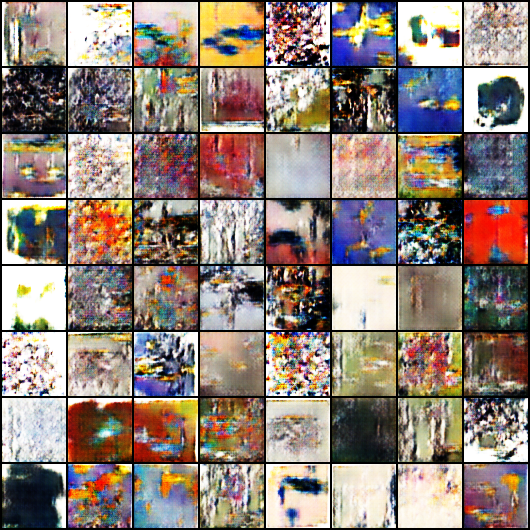

In [30]:
from IPython.display import Image
Image('./generated/generated-images-0195.png')

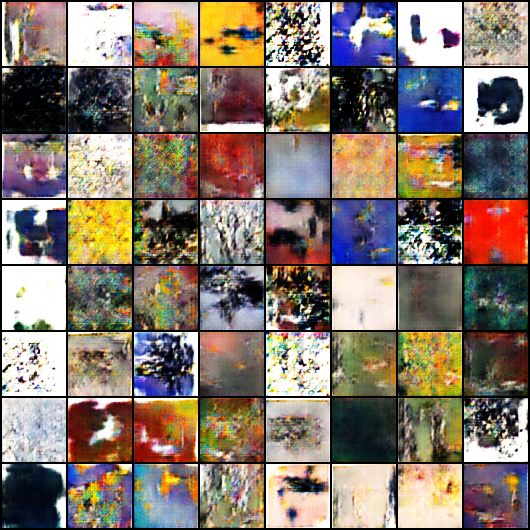

In [31]:
Image('./generated/generated-images-0196.png')

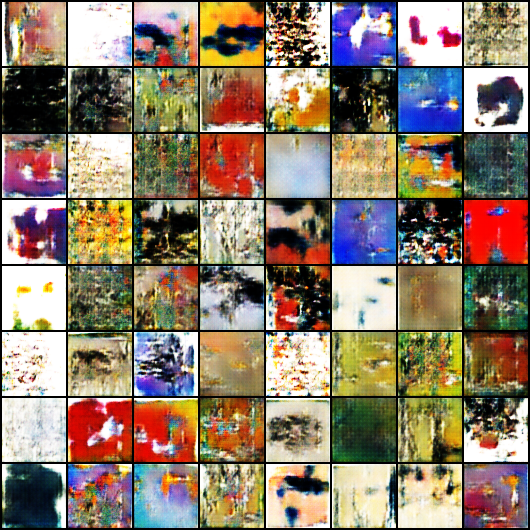

In [32]:
Image('./generated/generated-images-0197.png')

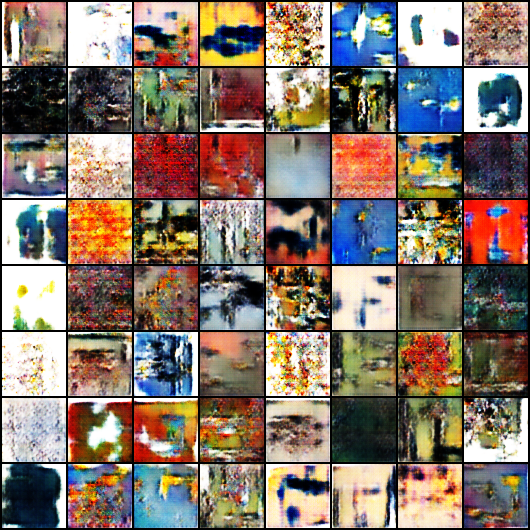

In [33]:
Image('./generated/generated-images-0198.png')

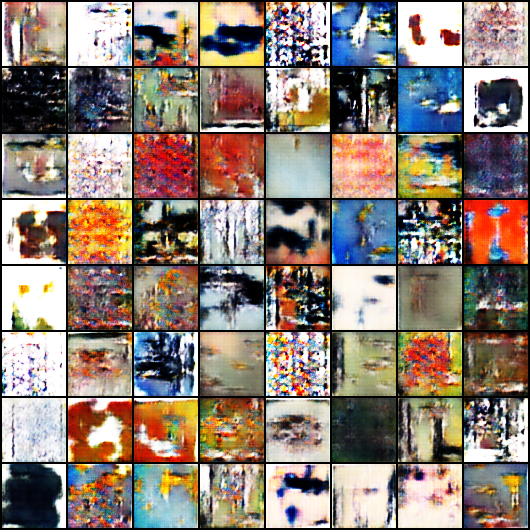

In [34]:
Image('./generated/generated-images-0199.png')

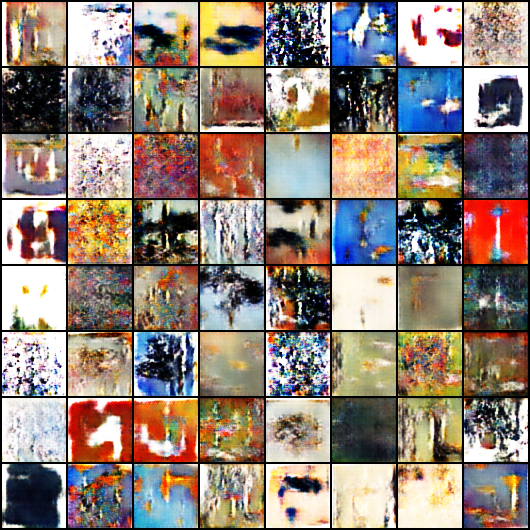

In [35]:
Image('./generated/generated-images-0200.png')

> Loss and score charts

In [25]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

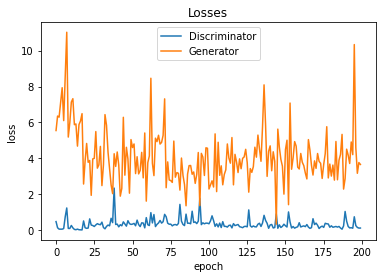

In [26]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

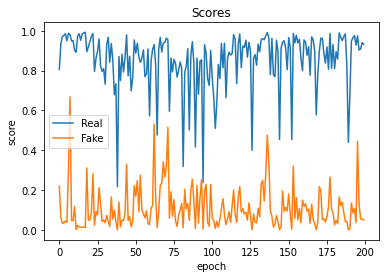

In [27]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [27]:
n